# Call compartment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
from glob import glob
import time
import cooler
import hba_data
from itertools import cycle, islice
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from concurrent.futures import ProcessPoolExecutor, as_completed

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
indir = '/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/'
outdir = '/home/jzhou_salk_edu/sky_workdir/hba/compartment_majortype/'


In [3]:
res = 100000
chrom_size_path = '/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:23]


In [4]:
cpg = pd.read_csv('/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.100kbin.CpG.txt', header=0, index_col=3, sep='\t')
cpg['CpG_density'] = cpg['14_user_patt_count'] / (cpg['13_seq_len'] - cpg['11_num_N'])


## Fit PC model with merged raw

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
chrX


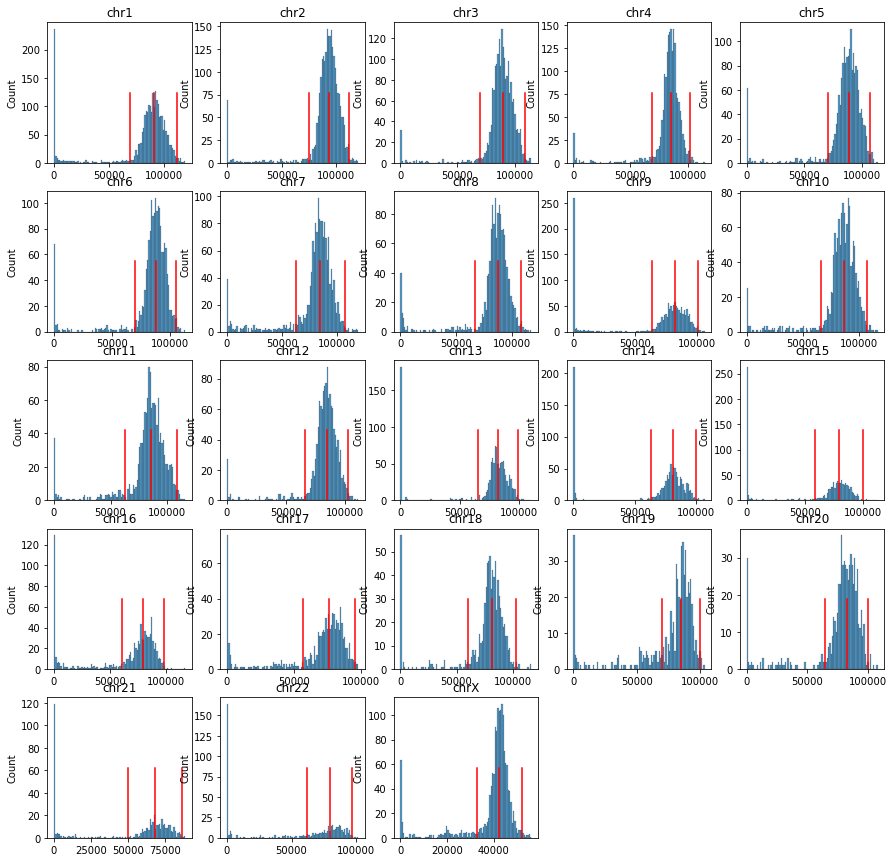

In [7]:
Qall = []
binall = []
ct = 'merged'
# cool = cooler.Cooler(f'/gale/netapp/entex/HBA/snm3C/compartment_majortype/{ct}/{ct}.raw.mcool::resolutions/100000')
cool = cooler.Cooler(f'{indir}{ct}/{ct}/{ct}.raw.mcool::resolutions/100000')
fig, axes = plt.subplots(5, 5, figsize=(15,15))
for i,c in enumerate(chrom_sizes.index):
    Q = cool.matrix(balance=False, sparse=True).fetch(c).toarray()
    Q = Q - np.diag(np.diag(Q))
    rowsum = Q.sum(axis=0)
    thres = [np.percentile(rowsum[rowsum>0], 50), np.percentile(rowsum[rowsum>0], 99)]
    thres.append(thres[0]*2-thres[1])
    ax = axes.flatten()[i]
    sns.histplot(rowsum, bins=100, ax=ax)
    for t in thres:
        ax.plot([t, t], [0, ax.get_ylim()[1]*0.5], c='r')
    ax.set_title(c)
    binfilter = (rowsum>thres[-1])
    binall.append(binfilter)
    Q = Q[binfilter][:, binfilter]
    Qall.append(Q)
    print(c)

for i in range(chrom_sizes.shape[0], axes.flatten().shape[0]):
    axes.flatten()[i].axis('off')
    

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


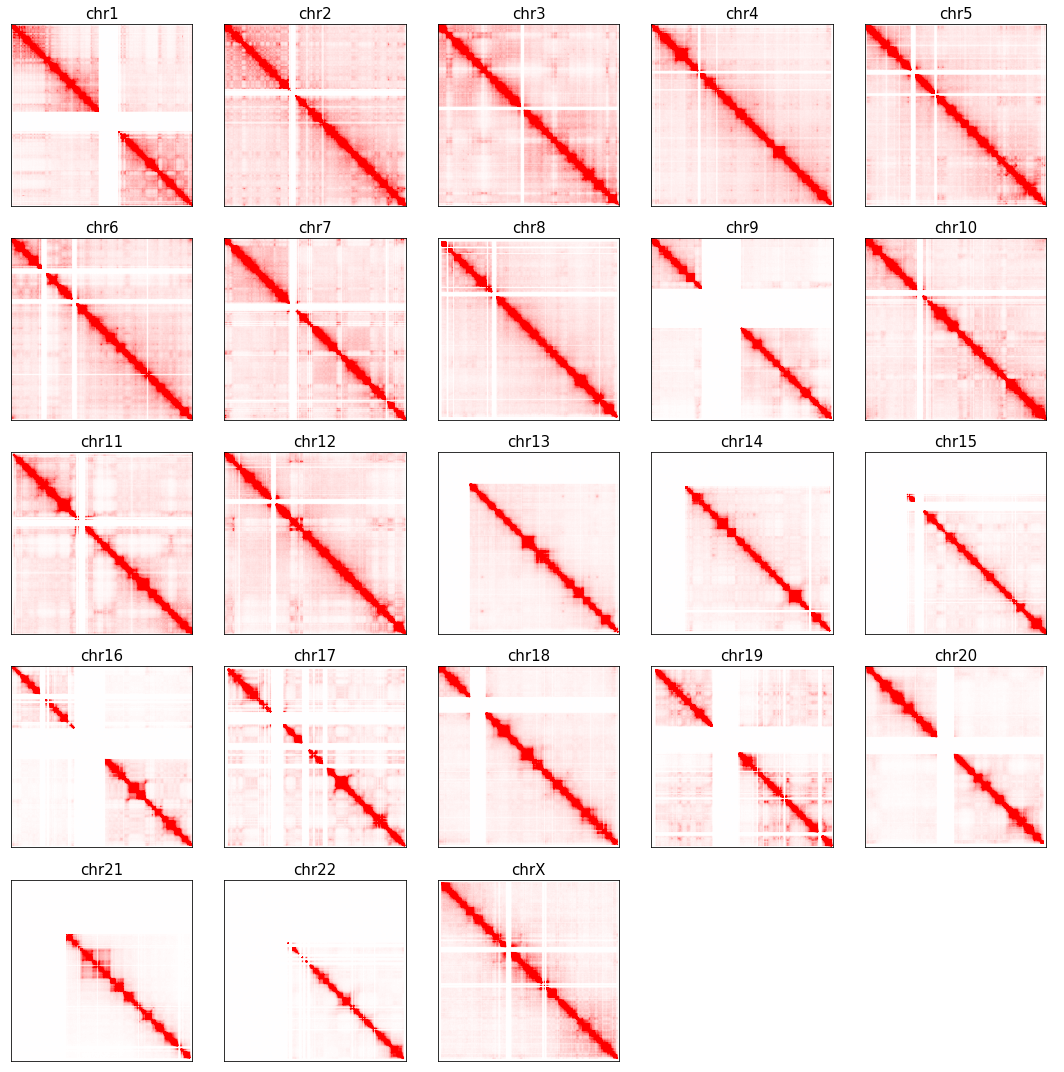

In [11]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
for i,c in enumerate(chrom_sizes.index):
    ax = axes.flatten()[i]
    n_bins = int(chrom_sizes[c] // 100000) + 1
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binall[i], binall[i])] = Qall[i]
    ax.imshow(tmp, cmap='bwr', vmin=-np.percentile(Qall[i], 95), vmax=np.percentile(Qall[i], 95))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(c, fontsize=15)

for i in range(chrom_sizes.shape[0], axes.flatten().shape[0]):
    axes.flatten()[i].axis('off')
    
plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_A_decay.pdf', transparent=True)


In [12]:
# comp = pd.read_hdf(f'{indir}compartment_majortype/comp_raw_merged.hdf', key='data')

Call = []
pcall = []
modelall = []
for k,chrom in enumerate(chrom_sizes.index[:-1]):
    Q = Qall[k].copy()
    decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
    E = np.zeros(Q.shape)
    row, col = np.diag_indices(E.shape[0])
    E[row, col] = 1
    for i in range(1, E.shape[0]):
        E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
    E = E + E.T
    C = np.corrcoef(np.log2(E + 0.001))
    Call.append(C)
    binfilter = binall[k]
#     tmp = comp.loc[ct, (comp.columns.str.split('_').str[0]==chrom)]
#     tmp.index = [int(xx.split('_')[1]) for xx in tmp.index]
#     pcall.append(tmp[np.where(binfilter)[0]].values)
    pca = PCA(n_components=2)
    pc = pca.fit_transform(C)
    cpgtmp = cpg.loc[cpg['#1_usercol']==chrom, 'CpG_density'].values[binfilter]
#     i = 0
#     if np.abs(pearsonr(cpgtmp, pc[:,0])[0])>np.abs(pearsonr(cpgtmp, pc[:,1])[0]):
#         i = 0
#     else:
#         i = 1
    r = []
    for i in range(2):
        labels, groups = pd.qcut(pc[:,i], 50, labels=False, retbins=True)
        sad = np.array([[E[np.ix_(labels==i, labels==j)].sum() for i in range(50)] for j in range(50)])
        count = np.array([[(labels==i).sum()*(labels==j).sum() for i in range(50)] for j in range(50)])
        sad = sad / count
        r.append((sad[:10, :10].sum() + sad[-10:, -10:].sum()) / (sad[:10, -10:].sum() + sad[-10:, :10].sum()))
    if r[0]>r[1]:
        i = 0
    else:
        i = 1
    if pearsonr(cpgtmp, pc[:,i])[0]>0:
        pc = pc[:,i]
        modelall.append(pca.components_[i])
    else:
        pc = -pc[:,i]
        modelall.append(-pca.components_[i])
    pcall.append(pc)
    print(chrom, i)


chr1 0
chr2 0
chr3 0
chr4 0
chr5 0
chr6 0
chr7 0
chr8 0
chr9 0
chr10 0
chr11 0
chr12 0
chr13 0
chr14 0
chr15 0
chr16 0
chr17 0
chr18 0
chr19 0
chr20 0
chr21 0
chr22 0


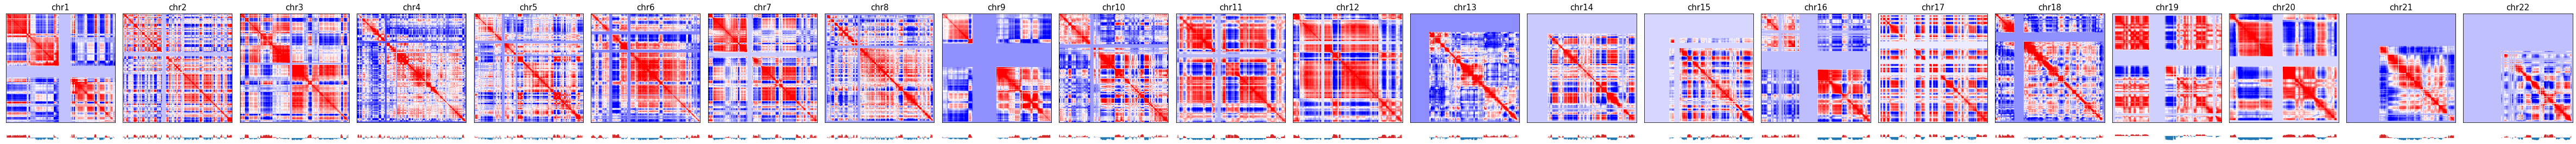

In [15]:
fig, axes = plt.subplots(2, 22, figsize=(66,4), gridspec_kw={'height_ratios':[5,0.2]}, sharex='col')
for i,c in enumerate(chrom_sizes.index[:-1]):
    ax = axes[0,i]
    n_bins = int(chrom_sizes[c] // 100000) + 1
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binall[i], binall[i])] = Call[i]
    ax.imshow(tmp, cmap='bwr', vmin=np.percentile(Call[i], 5), vmax=np.percentile(Call[i], 95))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(c, fontsize=15)

    ax = axes[1,i]
    # ax.set_title('PC1', fontsize=10)
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binall[i]] = pcall[i]# / np.std(pcall[i])
    x, y = np.arange(n_bins), tmp
    # x, y = np.arange(pcall[i].shape[0]), pcall[i]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_compraw.pdf', transparent=True)


In [16]:
np.save(f'{outdir}binfilter_raw.npy', binall)
np.save(f'{outdir}pcloading_raw.npy', modelall)


## Saddle plot of merged raw pc transformed compartment

In [6]:
leg = ['L23_IT', 'L4_IT', 'L56_NP', 'L5_ET', 'L5_IT', 'L6_CT', 'L6_IT', 'L6_IT_Car3', 'L6b', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 
       'MSN_D1', 'MSN_D2', 'SubCtx', 'Amy', 'CHD7', 'Foxp2', 
       'ASC', 'ODC', 'OPC', 'MGC', 'EC', 'PC', 'VLMC', 'merged']
legname = ['L2/3-IT', 'L4-IT', 'L5/6-NP', 'L5-ET', 'L5-IT', 'L6-CT', 'L6-IT', 'L6-IT-Car3', 'L6b', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 
       'MSN-D1', 'MSN-D2', 'SubCtx-Cplx', 'Amy-Exc', 'Chd7', 'Foxp2', 
       'ASC', 'ODC', 'OPC', 'MGC', 'EC', 'PC', 'VLMC', 'merged'
      ]


In [7]:
# binall = np.load(f'{outdir}binfilter_raw.npy', allow_pickle=True)
# modelall = np.load(f'{outdir}pcloading_raw.npy', allow_pickle=True)


In [8]:
def compsaddle(cool):
    sad = np.zeros((50, 50))
    count = np.zeros((50, 50))
    comptmp = []
    for k,chrom in enumerate(chrom_sizes.index[:-1]):
        Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
        Q = Q - np.diag(np.diag(Q))
        pc = np.zeros(Q.shape[0])
        binfilter = binall[k]
        Q = Q[binfilter][:, binfilter]
        decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
        E = np.zeros(Q.shape)
        row, col = np.diag_indices(E.shape[0])
        E[row, col] = 1
        for i in range(1, E.shape[0]):
            E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
        E = E + E.T
        C = np.corrcoef(np.log2(E + 0.001))
        pc = (C-np.mean(C, axis=0)).dot(modelall[k])
        comptmp.append(pc)
        labels, groups = pd.qcut(pc, 50, labels=False, retbins=True)
        sad += np.array([[E[np.ix_(labels==i, labels==j)].sum() for i in range(50)] for j in range(50)])
        count += np.array([[(labels==i).sum()*(labels==j).sum() for i in range(50)] for j in range(50)])
    return np.concatenate(comptmp), sad, count


In [9]:
mode = 'raw'
sad = np.zeros((len(leg),50,50))
count = np.zeros((len(leg),50,50))
comp = []


In [10]:
cpu = 10
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for t,ct in enumerate(leg):
        if mode=='impute':
            cool = cooler.Cooler(f'{indir}{ct}/{ct}.Q.cool')
        elif mode=='raw':
            cool = cooler.Cooler(f'{indir}{ct}/{ct}/{ct}.raw.mcool::resolutions/100000')
        future = executor.submit(
            compsaddle,
            cool=cool,
        )
        futures[future] = t

    for future in as_completed(futures):
        t = futures[future]
        ct = leg[t]
        xx, yy, zz = future.result()
        comp.append(pd.Series(xx, name=ct))
        sad[t] += yy
        count[t] += zz
        print(f'{ct} finished')
        

L5_ET finished
L56_NP finished
L23_IT finished
L4_IT finished
L6_IT finished
L6b finished
L5_IT finished
L6_IT_Car3 finished
Lamp5 finished
L6_CT finished
Lamp5_LHX6 finished
SubCtx finished
Sncg finished
Pvalb_ChC finished
Vip finished
Pvalb finished
Sst finished
MSN_D1 finished
MSN_D2 finished
Amy finished
CHD7 finished
Foxp2 finished
OPC finished
ODC finished
ASC finished
VLMC finished
EC finished
PC finished
MGC finished
merged finished


In [11]:
bins_df = cool.bins()[:]
bins_df.index = bins_df['chrom'].astype(str) + '-' + (bins_df['start'] // res).astype(str)
compidx = np.concatenate([bins_df.index[bins_df['chrom']==c][binall[i]] for i,c in enumerate(chrom_sizes.index[:-1])])


In [13]:
comp = pd.concat(comp, axis=1)
comp.index = compidx
comp.to_hdf(f'{outdir}comp_{mode}_mergerawpca.hdf', key='data')


In [14]:
sad = sad / count
np.save(f'{outdir}saddle_{mode}_mergerawpca.npy', sad)


In [15]:
ws = 10
compstr = [[sad[i][:ws, :ws].mean(), sad[i][-ws:, -ws:].mean(), sad[i][:ws, -ws:].mean(), sad[i][-ws:, :ws].mean(), 
            (sad[i][:ws, :ws].sum() + sad[i][-ws:, -ws:].sum()) / (sad[i][:ws, -ws:].sum() + sad[i][-ws:, :ws].sum())]
            for i in range(len(leg))]
compstr = pd.DataFrame(compstr, index=leg, columns=['BB', 'AA', 'BA', 'AB', 'strength'])
compstr.sort_values('strength')


,BB,AA,BA,AB,strength
L5_ET,1.348505,1.262203,0.708481,0.708481,1.842468
L6b,1.291788,1.330709,0.683750,0.683750,1.917731
SubCtx,1.236652,1.368936,0.658978,0.658978,1.976991
L6_IT_Car3,1.299906,1.325469,0.626082,0.626082,2.096671
L56_NP,1.311511,1.331668,0.626919,0.626919,2.108070
L6_IT,1.298863,1.347858,0.623379,0.623379,2.122883
Amy,1.343647,1.332711,0.614503,0.614503,2.177662
Foxp2,1.291581,1.370952,0.607887,0.607887,2.189991
Sncg,1.345780,1.375168,0.619657,0.619657,2.195527
L6_CT,1.291535,1.397869,0.611131,0.611131,2.200350


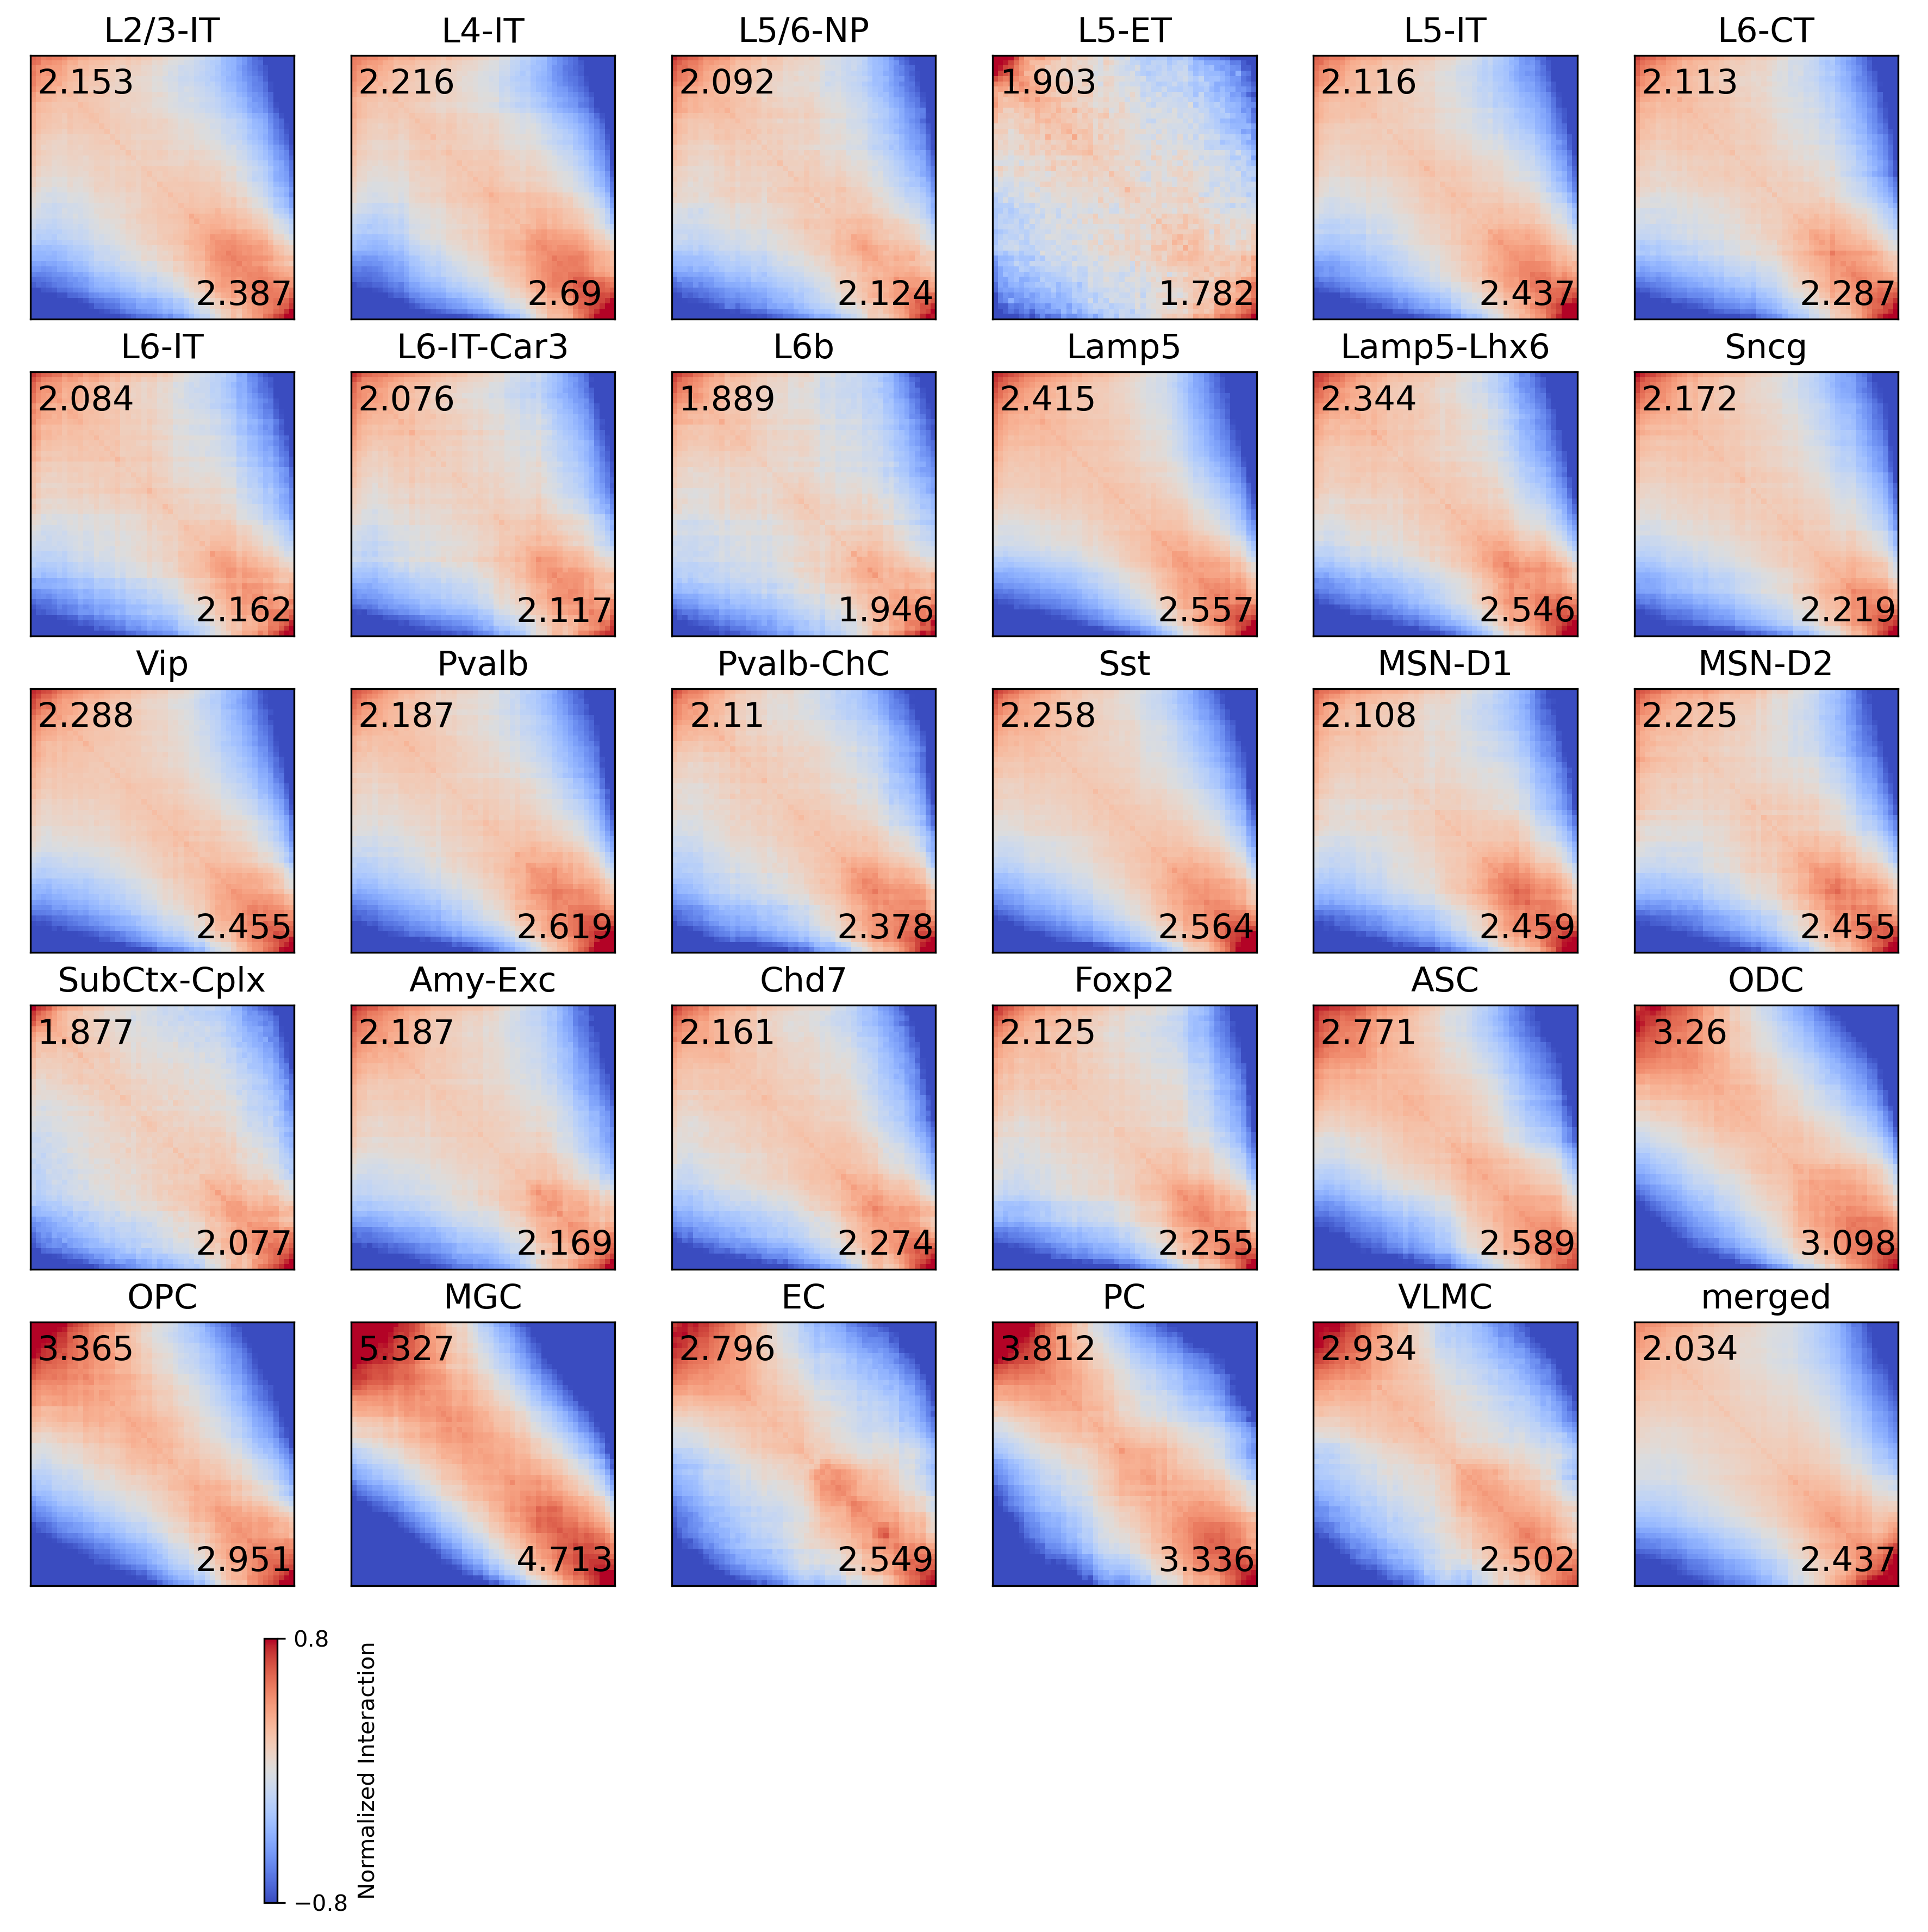

In [17]:
# raw
vmin, vmax = -0.8, 0.8
fig, axes = plt.subplots(((len(leg))//6+1), 6, figsize=(15,15), dpi=300)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
for i,xx in enumerate(leg):
    ax = axes.flatten()[i]
    plot = ax.imshow(np.log2(sad[i]+0.001), cmap='coolwarm', vmin=vmin, vmax=vmax)
    # plot = ax.imshow(sad[i], cmap='coolwarm', vmin=0, vmax=2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(legname[i], fontsize=15)
    ax.text(40, 45, np.around(compstr.loc[xx, 'AA']/compstr.loc[xx, 'AB'], decimals=3), ha='center', va='center', fontsize=15)
    ax.text(10, 5, np.around(compstr.loc[xx, 'BB']/compstr.loc[xx, 'BA'], decimals=3), ha='center', va='center', fontsize=15)

cbar = plt.colorbar(plot, ax=axes.flatten()[len(leg)])
cbar.set_ticks([vmin,vmax])
cbar.set_label('Normalized Interaction')

for ax in axes.flatten()[len(leg):]:
    ax.axis('off')
    
# plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_saddle_raw.pdf', transparent=True)

